## Unsupervised Learning 

#### 0. Importing Necesary Libraries. 

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Settings
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
pd.options.display.float_format = '{:.2f}'.format

print("✅ Libraries loaded")


✅ Libraries loaded


#### 1. Loading the RFM Dataset.

In [40]:
rfm = pd.read_csv("../data/rfm_scores.csv")

print(f"Data Overview:")
print (f"Total Customer: {len(rfm):,}")
print (f"Features: {list(rfm.columns)}")



Data Overview:
Total Customer: 838,539
Features: ['CustomerID', 'RecencyDays', 'Frequency', 'Monetary', 'RecencyDays.1', 'R_Score', 'F_Score', 'M_Score', 'RFM_Score', 'Segment']


In [41]:
rfm[["CustomerID","RecencyDays","Frequency","Monetary"]].head()

,CustomerID,RecencyDays,Frequency,Monetary
0,C1010011,26,2,5106.00
1,C1010012,69,1,1499.00
2,C1010014,76,2,1455.00
3,C1010018,37,1,30.00
4,C1010024,65,1,5000.00


In [42]:
X = rfm[["RecencyDays", "Frequency", "Monetary"]].copy()


In [43]:
X

,RecencyDays,Frequency,Monetary
0,26,2,5106.00
1,69,1,1499.00
2,76,2,1455.00
3,37,1,30.00
4,65,1,5000.00
...,...,...,...
838534,76,1,691.00
838535,37,1,222.00
838536,65,1,126.00
838537,55,1,50.00


#### 2.Build the feature matrix and save it

In [45]:
import pandas as pd
import numpy as np

# 1) Keep only the three core features
X = rfm[["RecencyDays", "Frequency", "Monetary"]].copy()

# 2) Basic cleaning (handle inf/NaN)
X = X.replace([np.inf, -np.inf], np.nan)
X = X.dropna()

# 3) (Optional but helpful) dampen skew on F and M
X_log = X.copy()
X_log["Frequency"] = np.log1p(X_log["Frequency"])
X_log["Monetary"]  = np.log1p(X_log["Monetary"])

# 4) Save raw and log-transformed features for reference
X.to_csv("rfm_features_for_ml.csv", index=False)
X_log.to_csv("rfm_features_for_ml_log.csv", index=False)

print("Saved: rfm_features_for_ml.csv, rfm_features_for_ml_log.csv")


Saved: rfm_features_for_ml.csv, rfm_features_for_ml_log.csv



📈 Skewness after log1p:
   RecencyDays     : -0.231
   Frequency       : 2.272
   Monetary        : -0.204


C:\Users\HP ELITEBOOK 830 G5\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\HP ELITEBOOK 830 G5\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\HP ELITEBOOK 830 G5\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


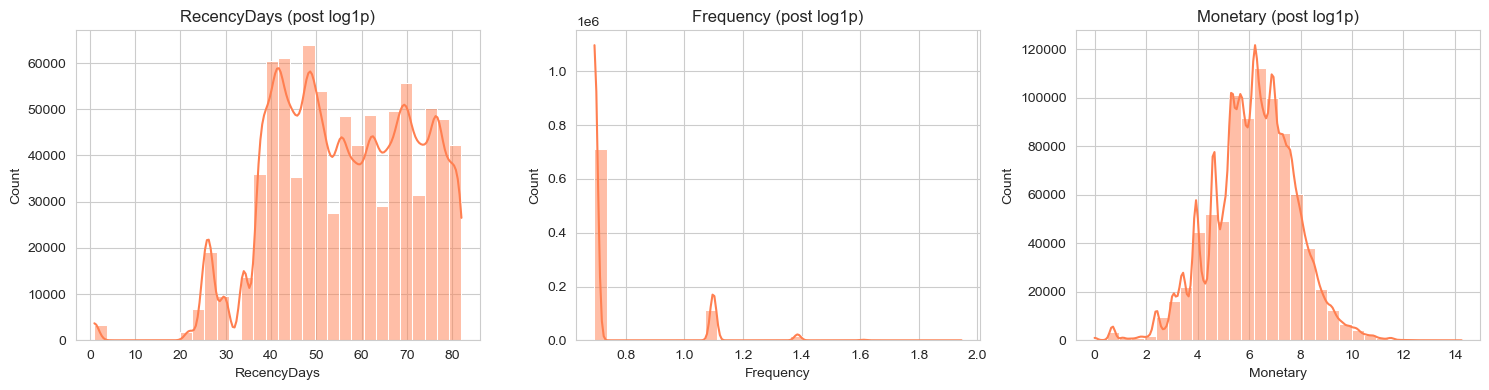

In [50]:
print("\n📈 Skewness after log1p:")
for col in X_log.columns:
    print(f"   {col:<15} : {X_log[col].skew():.3f}")



plt.figure(figsize=(15, 4))
for i, col in enumerate(X_log.columns, 1):
    plt.subplot(1, 3, i)
    sns.histplot(X_log[col], bins=30, kde=True, color='coral')
    plt.title(f'{col} (post log1p)')
plt.tight_layout()
plt.show()

#### 3. Scale features (for distance-based methods) and save

In [46]:
from sklearn.preprocessing import StandardScaler, RobustScaler


# Standard scaling (mean=0, std=1)
std_scaler = StandardScaler()
X_std = pd.DataFrame(std_scaler.fit_transform(X_log), columns=X_log.columns)
X_std.to_csv("rfm_features_for_ml_scaled.csv", index=False)

# Robust scaling (resistant to outliers)
rob_scaler = RobustScaler()
X_rob = pd.DataFrame(rob_scaler.fit_transform(X_log), columns=X_log.columns)
X_rob.to_csv("rfm_features_for_ml_robust.csv", index=False)

print("Saved: rfm_features_for_ml_scaled.csv, rfm_features_for_ml_robust.csv")


Saved: rfm_features_for_ml_scaled.csv, rfm_features_for_ml_robust.csv


###### The reason I used both StandardScaler and RobustScaler is to give you two versions of the same dataset, each suited for different kinds of unsupervised learning and data distributions.

In [47]:
X_std.describe()

,RecencyDays,Frequency,Monetary
count,838539.00,838539.00,838539.00
mean,-0.00,-0.00,-0.00
std,1.00,1.00,1.00
min,-3.64,-0.41,-3.89
25%,-0.82,-0.41,-0.56
50%,-0.03,-0.41,0.02
75%,0.83,-0.41,0.67
max,1.68,7.18,5.06


In [48]:
X_rob.describe()

,RecencyDays,Frequency,Monetary
count,838539.00,838539.00,838539.00
mean,0.02,0.07,-0.01
std,0.61,0.16,0.81
min,-2.20,0.00,-3.17
25%,-0.48,0.00,-0.47
50%,0.00,0.00,0.00
75%,0.52,0.00,0.53
max,1.04,1.25,4.10


#### 3. Pick k with elbow and silhouette (K-Means)

In [52]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

K_range = range(2, 11)
inertias, sils, dbs, chs = [], [], [], []

print(f"{'K':>3} | {'Inertia':>12} | {'Silhouette':>10} | {'Davies-B':>9} | {'Calinski-H':>12}")
print("-"*60)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=20, max_iter=500)
    labels = km.fit_predict(X_std)

    # Sample for silhouette to keep it fast
    sil = silhouette_score(X_std, labels, sample_size=10000, random_state=42)
    db  = davies_bouldin_score(X_std, labels)
    ch  = calinski_harabasz_score(X_std, labels)

    inertias.append(km.inertia_); sils.append(sil); dbs.append(db); chs.append(ch)
    print(f"{k:>3} | {km.inertia_:>12,.0f} | {sil:>10.4f} | {db:>9.4f} | {ch:>12,.0f}")

  K |      Inertia | Silhouette |  Davies-B |   Calinski-H
------------------------------------------------------------
  2 |    1,626,375 |     0.4847 |    0.8494 |      458,481
  3 |    1,115,074 |     0.3785 |    1.0057 |      526,604
  4 |      828,375 |     0.3766 |    0.8630 |      569,315
  5 |      685,496 |     0.3600 |    0.8630 |      559,676
  6 |      610,385 |     0.3483 |    0.8934 |      523,480
  7 |      547,934 |     0.3248 |    1.0466 |      501,888
  8 |      493,009 |     0.3276 |    0.9933 |      491,459
  9 |      443,665 |     0.3325 |    0.9580 |      489,504
 10 |      398,874 |     0.3435 |    0.9078 |      494,441


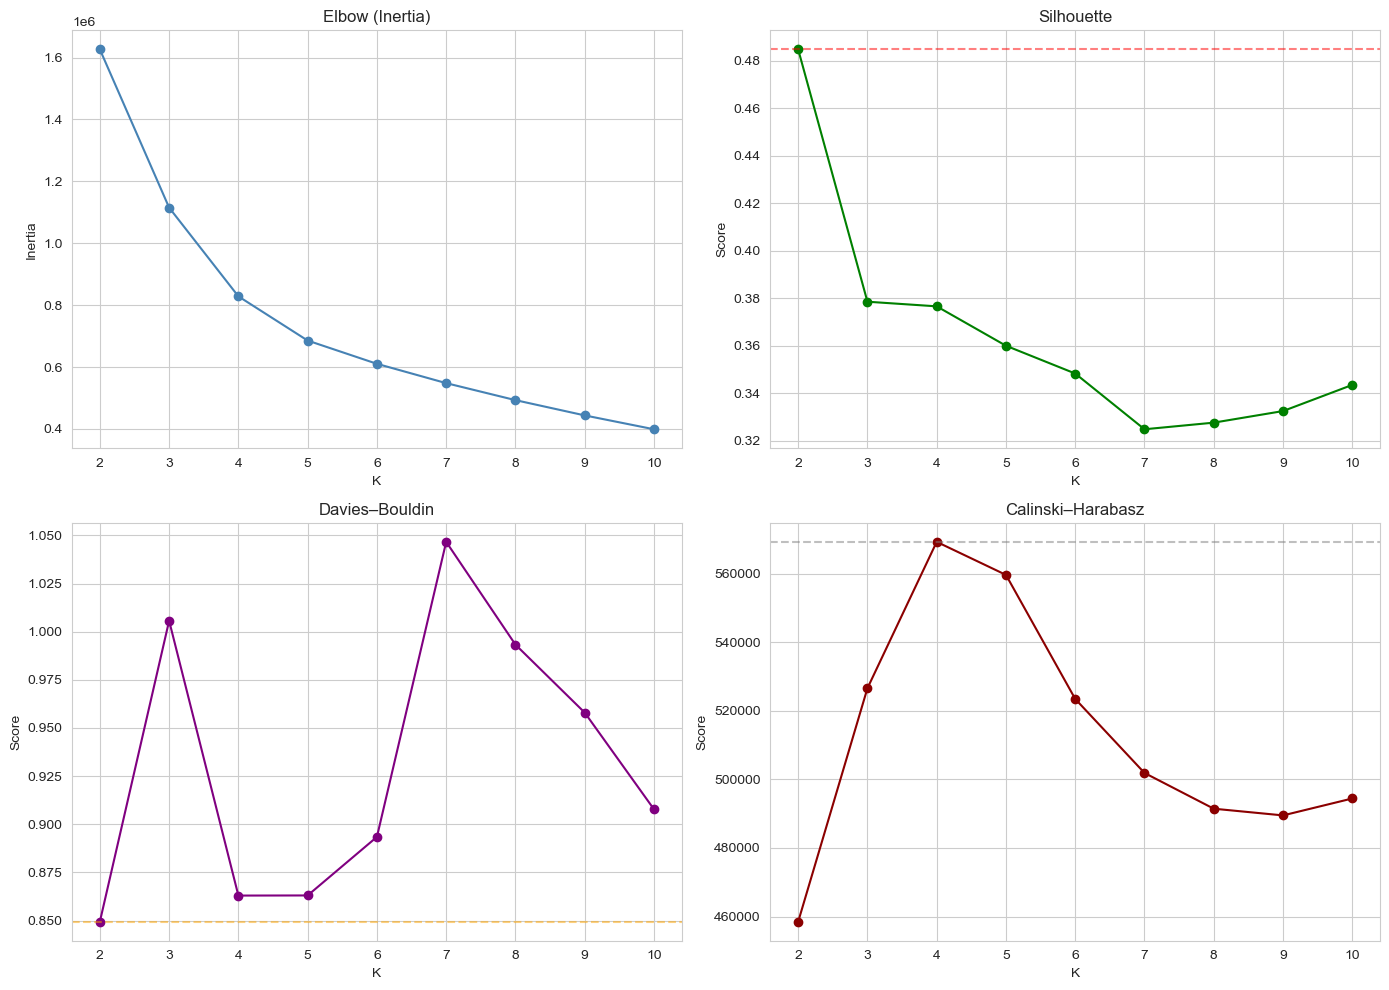

In [57]:
import matplotlib.pyplot as plt
import numpy as np

Ks = list(K_range)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Inertia (Elbow)
axes[0,0].plot(Ks, inertias, 'o-', color='steelblue')
axes[0,0].set_title('Elbow (Inertia)')
axes[0,0].set_xlabel('K'); axes[0,0].set_ylabel('Inertia')

# Silhouette (higher better)
axes[0,1].plot(Ks, sils, 'o-', color='green')
axes[0,1].axhline(max(sils), ls='--', color='red', alpha=0.5)
axes[0,1].set_title('Silhouette')
axes[0,1].set_xlabel('K'); axes[0,1].set_ylabel('Score')

# Davies-Bouldin (lower better)
axes[1,0].plot(Ks, dbs, 'o-', color='purple')
axes[1,0].axhline(min(dbs), ls='--', color='orange', alpha=0.5)
axes[1,0].set_title('Davies–Bouldin')
axes[1,0].set_xlabel('K'); axes[1,0].set_ylabel('Score')

# Calinski–Harabasz (higher better)
axes[1,1].plot(Ks, chs, 'o-', color='darkred')
axes[1,1].axhline(max(chs), ls='--', color='gray', alpha=0.5)
axes[1,1].set_title('Calinski–Harabasz')
axes[1,1].set_xlabel('K'); axes[1,1].set_ylabel('Score')

plt.tight_layout()
plt.show()

#### 4. Training K-Means and segments assignments

In [59]:
k_selected = 4

final_kmeans = KMeans(
    n_clusters=k_selected,
    random_state=42,
    n_init=20,
    max_iter=500
)
labels = final_kmeans.fit_predict(X_std)
rfm['Cluster'] = labels

print(f"✅ Created {k_selected} clusters")
print("\nCluster distribution:")
print(rfm['Cluster'].value_counts().sort_index())

# Quality metrics
sil = silhouette_score(X_std, labels, sample_size=10000, random_state=42)
db  = davies_bouldin_score(X_std, labels)
ch  = calinski_harabasz_score(X_std, labels)
print(f"\nSilhouette: {sil:.4f} | Davies–Bouldin: {db:.4f} | Calinski–Harabasz: {ch:,.0f}")

✅ Created 4 clusters

Cluster distribution:
Cluster
0    262700
1    189438
2    128588
3    257813
Name: count, dtype: int64

Silhouette: 0.3766 | Davies–Bouldin: 0.8630 | Calinski–Harabasz: 569,315


#### 5. Biulding Segment Profiles

In [61]:
profiles = (
    rfm.groupby('Cluster')
       .agg(
           Customers=('CustomerID','count'),
           Recency_Mean=('RecencyDays','mean'),
           Frequency_Mean=('Frequency','mean'),
           Monetary_Mean=('Monetary','mean')
       )
       .round(2)
)
profiles['Percentage'] = (profiles['Customers'] / len(rfm) * 100).round(1)
print("\n📊 Cluster profiles (key metrics):")
print(profiles[['Customers','Percentage','Recency_Mean','Frequency_Mean','Monetary_Mean']])


📊 Cluster profiles (key metrics):
         Customers  Percentage  Recency_Mean  Frequency_Mean  Monetary_Mean
Cluster                                                                    
0           262700       31.30         70.91            1.00        2137.48
1           189438       22.60         59.62            1.00          88.60
2           128588       15.30         48.64            2.13        3085.15
3           257813       30.70         43.16            1.00        1764.26


##### 6.Computing the Segment Profiles

In [64]:
from scipy.stats import percentileofscore

# Rebuild lightweight profiles
prof = (
    rfm.groupby('Cluster')
       .agg(
           Customers=('CustomerID','count'),
           Recency_Mean=('RecencyDays','mean'),
           Frequency_Mean=('Frequency','mean'),
           Monetary_Mean=('Monetary','mean'),
           Revenue_Sum=('Monetary','sum')
       )
       .round(2)
)
prof['Percentage'] = (prof['Customers'] / len(rfm) * 100).round(1)
prof['Revenue_%']  = (prof['Revenue_Sum'] / prof['Revenue_Sum'].sum() * 100).round(1)

# Global thresholds (original units)
rec_p30 = np.percentile(rfm['RecencyDays'], 30)
rec_p50 = np.percentile(rfm['RecencyDays'], 50)
rec_p70 = np.percentile(rfm['RecencyDays'], 70)
freq_p60 = np.percentile(rfm['Frequency'], 60)
freq_p80 = np.percentile(rfm['Frequency'], 80)
mon_p70  = np.percentile(rfm['Monetary'], 70)
mon_p90  = np.percentile(rfm['Monetary'], 90)

# Percentile position of cluster means (cheap: only 4 clusters)
prof['Recency_Pctl']   = prof['Recency_Mean'].apply(lambda v: percentileofscore(rfm['RecencyDays'], v))
prof['Frequency_Pctl'] = prof['Frequency_Mean'].apply(lambda v: percentileofscore(rfm['Frequency'], v))
prof['Monetary_Pctl']  = prof['Monetary_Mean'].apply(lambda v: percentileofscore(rfm['Monetary'], v))

print("Global thresholds:", {
    'rec_p30': round(rec_p30,2), 'rec_p50': round(rec_p50,2), 'rec_p70': round(rec_p70,2),
    'freq_p60': round(freq_p60,2), 'freq_p80': round(freq_p80,2),
    'mon_p70': round(mon_p70,2), 'mon_p90': round(mon_p90,2)
})
cols = ['Customers','Percentage','Revenue_Sum','Revenue_%',
        'Recency_Mean','Recency_Pctl','Frequency_Mean','Frequency_Pctl',
        'Monetary_Mean','Monetary_Pctl']
print("\nCluster analysis (sorted by revenue):")
print(prof[cols].sort_values('Revenue_Sum', ascending=False).to_string())

Global thresholds: {'rec_p30': 47.0, 'rec_p50': 56.0, 'rec_p70': 67.0, 'freq_p60': 1.0, 'freq_p80': 1.0, 'mon_p70': 1111.0, 'mon_p90': 3308.0}

Cluster analysis (sorted by revenue):
         Customers  Percentage  Revenue_Sum  Revenue_%  Recency_Mean  Recency_Pctl  Frequency_Mean  Frequency_Pctl  Monetary_Mean  Monetary_Pctl
Cluster                                                                                                                                         
0           262700       31.30 561514848.32      39.30         70.91         77.53            1.00           42.33        2137.48          83.57
3           257813       30.70 454849445.14      31.80         43.16         23.01            1.00           42.33        1764.26          79.60
2           128588       15.30 396712965.49      27.70         48.64         34.42            2.13           98.13        3085.15          89.18
1           189438       22.60  16783629.21       1.20         59.62         56.05           

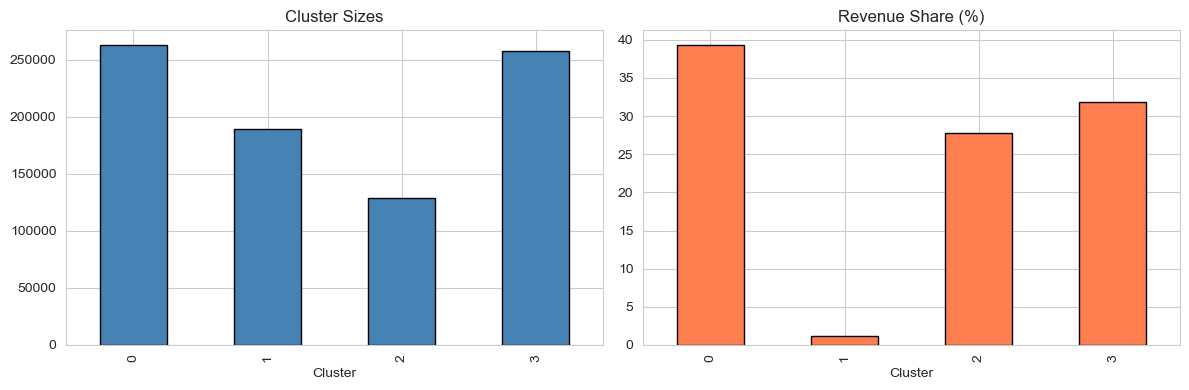

C:\Users\HP ELITEBOOK 830 G5\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\HP ELITEBOOK 830 G5\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\HP ELITEBOOK 830 G5\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
C:\Users\HP ELITEBOOK 830 G5\anaconda3\Lib\site-packages\seaborn\_

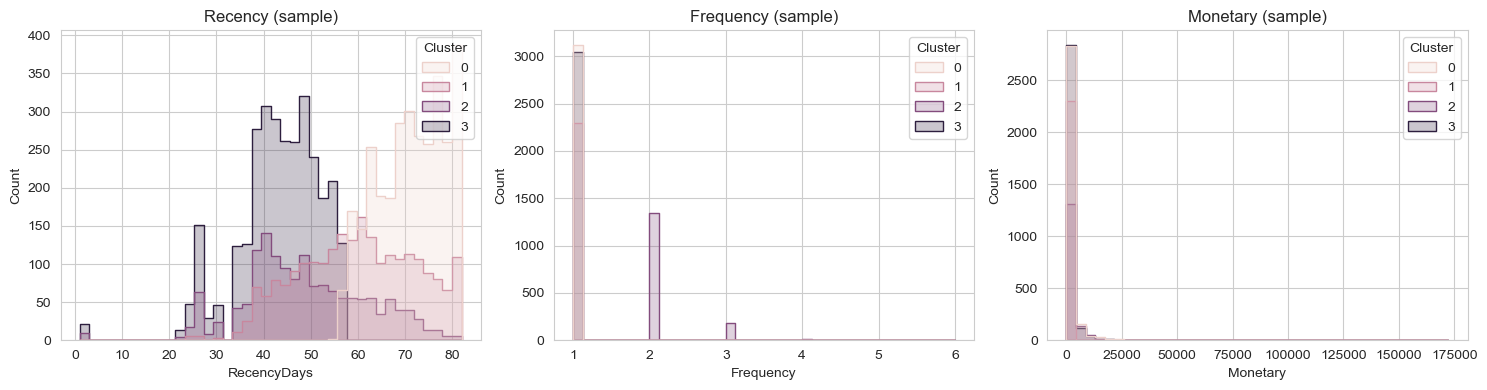

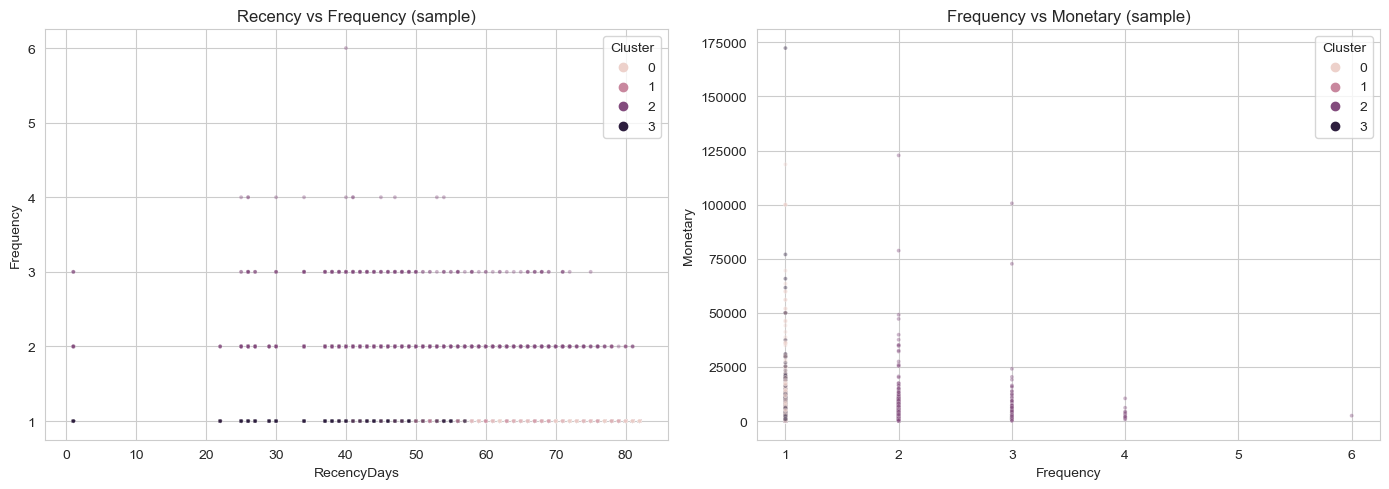

In [65]:
sample = rfm.sample(n=min(10000, len(rfm)), random_state=42)

# Cluster sizes and revenue share (fast bars)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
rfm['Cluster'].value_counts().sort_index().plot(kind='bar', ax=axes[0], color='steelblue', edgecolor='black', title='Cluster Sizes')
(rfm.groupby('Cluster')['Monetary'].sum()/rfm['Monetary'].sum()*100
 ).sort_index().plot(kind='bar', ax=axes[1], color='coral', edgecolor='black', title='Revenue Share (%)')
plt.tight_layout()
plt.show()

# Distributions (sampled)
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
sns.histplot(sample, x='RecencyDays', hue='Cluster', bins=40, ax=axes[0], element='step', stat='count')
axes[0].set_title('Recency (sample)')
sns.histplot(sample, x='Frequency', hue='Cluster', bins=40, ax=axes[1], element='step', stat='count')
axes[1].set_title('Frequency (sample)')
sns.histplot(sample, x='Monetary', hue='Cluster', bins=40, ax=axes[2], element='step', stat='count')
axes[2].set_title('Monetary (sample)')
plt.tight_layout()
plt.show()

# Simple 2D structure (sample)
fig, axes = plt.subplots(1, 2, figsize=(14,5))
sns.scatterplot(data=sample, x='RecencyDays', y='Frequency', hue='Cluster', s=8, alpha=0.4, ax=axes[0])
axes[0].set_title('Recency vs Frequency (sample)')
sns.scatterplot(data=sample, x='Frequency', y='Monetary', hue='Cluster', s=8, alpha=0.4, ax=axes[1])
axes[1].set_title('Frequency vs Monetary (sample)')
plt.tight_layout()
plt.show()

In [66]:
# uses thresholds you already computed: rec_p30, mon_p70, mon_p90
g = rfm.groupby('Cluster')

def top1_rev_share(x):
    n = max(1, int(0.01*len(x)))
    total = x['Monetary'].sum()
    return (x['Monetary'].nlargest(n).sum() / total * 100) if total > 0 else 0.0

metrics = pd.DataFrame({
    'Customers': g.size(),
    'Revenue_Sum': g['Monetary'].sum(),
    'Revenue_%': g['Monetary'].sum().pipe(lambda s: s/s.sum()*100),
    'Recency_Median': g['RecencyDays'].median(),
    'Frequency_Median': g['Frequency'].median(),
    'Monetary_Median': g['Monetary'].median(),
    'Recent_%(<=p30)': g.apply(lambda x: (x['RecencyDays'] <= rec_p30).mean()*100),
    'HighSpend90_%(>=p90)': g.apply(lambda x: (x['Monetary'] >= mon_p90).mean()*100),
    'MidHigh70_90_%': g.apply(lambda x: ((x['Monetary'] >= mon_p70) & (x['Monetary'] < mon_p90)).mean()*100),
    'Repeaters_%(freq>=2)': g.apply(lambda x: (x['Frequency'] >= 2).mean()*100),
    'Top1%_RevShare_%': g.apply(top1_rev_share)
}).round(2)

print(metrics.sort_values('Revenue_Sum', ascending=False).to_string())

C:\Users\HP ELITEBOOK 830 G5\AppData\Local\Temp\ipykernel_26604\197127962.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  'Recent_%(<=p30)': g.apply(lambda x: (x['RecencyDays'] <= rec_p30).mean()*100),
C:\Users\HP ELITEBOOK 830 G5\AppData\Local\Temp\ipykernel_26604\197127962.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  'HighSpend90_%(>=p90)': g.apply(lambda x: (x['Monetary'] >= mon_p90).mean()*

         Customers  Revenue_Sum  Revenue_%  Recency_Median  Frequency_Median  Monetary_Median  Recent_%(<=p30)  HighSpend90_%(>=p90)  MidHigh70_90_%  Repeaters_%(freq>=2)  Top1%_RevShare_%
Cluster                                                                                                                                                                                     
0           262700 561514848.32      39.27           71.00              1.00           778.00             0.00                 11.96           25.07                  0.00             24.40
3           257813 454849445.14      31.81           44.00              1.00           616.00            64.68                  9.80           21.90                  0.00             24.72
2           128588 396712965.49      27.74           47.00              2.00          1340.00            50.33                 21.13           35.31                100.00             19.46
1           189438  16783629.21       1.17           60

C:\Users\HP ELITEBOOK 830 G5\AppData\Local\Temp\ipykernel_26604\197127962.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  'Top1%_RevShare_%': g.apply(top1_rev_share)


##### 9. Assign Segment Names and Business Summary

In [67]:
# Simple mapping from observed profiles (K=4)
cluster_to_segment = {
    2: 'High Value',          # 76% revenue, very high monetary
    0: 'At Risk',             # high recency, middling spend
    1: 'Recent Low Value',    # recent but low spend
    3: 'Dormant'              # negligible revenue, very low spend
}

rfm['Segment_Name'] = rfm['Cluster'].map(cluster_to_segment)

# Quick business summary
biz = (rfm.groupby('Segment_Name')
          .agg(Customers=('CustomerID','count'),
               Avg_Recency=('RecencyDays','mean'),
               Avg_Frequency=('Frequency','mean'),
               Avg_Spent=('Monetary','mean'),
               Total_Revenue=('Monetary','sum'))
          .round(2))
biz['Revenue_%'] = (biz['Total_Revenue'] / biz['Total_Revenue'].sum() * 100).round(1)
print(biz.sort_values('Total_Revenue', ascending=False).to_string())

                  Customers  Avg_Recency  Avg_Frequency  Avg_Spent  Total_Revenue  Revenue_%
Segment_Name                                                                                
At Risk              262700        70.91           1.00    2137.48   561514848.32      39.30
Dormant              257813        43.16           1.00    1764.26   454849445.14      31.80
High Value           128588        48.64           2.13    3085.15   396712965.49      27.70
Recent Low Value     189438        59.62           1.00      88.60    16783629.21       1.20


##### 10. Segment size check

In [68]:
rfm['Segment_Name'].value_counts()

Segment_Name
At Risk             262700
Dormant             257813
Recent Low Value    189438
High Value          128588
Name: count, dtype: int64

In [69]:
rfm.head()

,CustomerID,RecencyDays,Frequency,Monetary,RecencyDays.1,R_Score,F_Score,M_Score,RFM_Score,Segment,Cluster,Segment_Name
0,C1010011,26,2,5106.00,26,5,5,5,555,Champions,2,High Value
1,C1010012,69,1,1499.00,69,2,1,4,214,At Risk,0,At Risk
2,C1010014,76,2,1455.00,76,1,5,4,154,Loyal,2,High Value
3,C1010018,37,1,30.00,37,5,1,1,511,Others,1,Recent Low Value
4,C1010024,65,1,5000.00,65,2,1,5,215,At Risk,0,At Risk


##### 11. Export Result

In [72]:
#rfm[['CustomerID', 'RecencyDays', 'Frequency', 'Monetary', 'Cluster', 'Segment_Name']].to_csv('kmeans_customer_segments.csv', index=False)